# Next Pitch Prediction using LSTMs

The first series of tests will be carried out using basic LSTMs. An LSTM is a type of recurrent neural network that is capable of learning long-term dependencies. This is particularly useful for time series data, such as the pitch sequences in this dataset.

## Data loading and sequencing

In [1]:
import os
import tensorflow as tf
import keras_tuner

os.chdir('../..')
tf.keras.utils.set_random_seed(42)

In [2]:
from utils import preprocessing
from sklearn.model_selection import train_test_split

X, y_pitch, y_vertical, y_horizontal = preprocessing.get_sequences(os.path.join('data', 'raw', 'wade_miley_15-21.csv'))

# Split the data into training, validation, and testing sets
X_train, X_temp, y_pitch_train, y_pitch_temp, y_vertical_train, y_vertical_temp, y_horizontal_train, y_horizontal_temp = train_test_split(
    X, y_pitch, y_vertical, y_horizontal, test_size=0.4, random_state=42)

X_val, X_test, y_pitch_val, y_pitch_test, y_vertical_val, y_vertical_test, y_horizontal_val, y_horizontal_test = train_test_split(
    X_temp, y_pitch_temp, y_vertical_temp, y_horizontal_temp, test_size=0.5, random_state=42)

num_pitches = y_pitch.shape[1]
num_vertical_locs = y_vertical.shape[1]
num_horizontal_locs = y_horizontal.shape[1]

In [3]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, activation='relu', dropout=0, return_sequences=True, reg=None):
    # Attention and Normalization
    x = tf.keras.layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = tf.keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation=activation, kernel_regularizer=reg)(res)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1, kernel_regularizer=reg)(x)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
    x = x + res

    if not return_sequences:
        x = tf.keras.layers.GlobalAveragePooling1D()(x)
    
    return x

In [4]:
def build_network(input_layer, num_targets, name='', num_hidden_layers=1, activation='relu', reg=None, dropout=0, head_size=256, num_heads=4, ff_dim=128):
    # Hidden layers
    x = input_layer
    for i in range(num_hidden_layers - 1):
        x = transformer_encoder(x, head_size=head_size, num_heads=num_heads, ff_dim=ff_dim, activation=activation, reg=reg, dropout=dropout)

    x = transformer_encoder(x, head_size=head_size, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout, return_sequences=False)
    
    # Output layer
    outputs = tf.keras.layers.Dense(units=num_targets, activation='softmax', name=f'{name}_output')(x)

    return outputs


In [5]:
def build_model(hp):
    # Define the input layer
    input_layer = tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2]))

    pitch_output = build_network(input_layer, num_targets=num_pitches, name='pitch',
                                 num_hidden_layers=hp.Int('num_hidden_layers', min_value=1, max_value=3, step=1),
                                 activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid']),
                                 head_size=hp.Choice('head_size', values=[32, 64, 128, 256]),
                                 num_heads=hp.Int('num_heads', min_value=2, max_value=4, step=2),
                                 ff_dim=hp.Choice('ff_dim', values=[64, 128, 256]))
    
    vertical_output = build_network(input_layer, num_targets=num_vertical_locs, name='vertical',
                                    num_hidden_layers=hp.Int('num_hidden_layers', min_value=1, max_value=3, step=1),
                                    activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid']),
                                    head_size=hp.Choice('head_size', values=[32, 64, 128, 256]),
                                    num_heads=hp.Int('num_heads', min_value=2, max_value=4, step=2),
                                    ff_dim=hp.Choice('ff_dim', values=[64, 128, 256]))
    
    horizontal_output = build_network(input_layer, num_targets=num_horizontal_locs, name='horizontal',
                                      num_hidden_layers=hp.Int('num_hidden_layers', min_value=1, max_value=3, step=1),
                                      activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid']),
                                      head_size=hp.Choice('head_size', values=[32, 64, 128, 256]),
                                      num_heads=hp.Int('num_heads', min_value=2, max_value=4, step=2),
                                      ff_dim=hp.Choice('ff_dim', values=[64, 128, 256]))

    # Combine the models
    ensemble_model = tf.keras.models.Model(inputs=input_layer, outputs=[
                                           pitch_output, vertical_output, horizontal_output])

    # Compile the model
    ensemble_model.compile(optimizer='adam',
                           loss={'pitch_output': 'categorical_crossentropy',
                                 'vertical_output': 'categorical_crossentropy',
                                 'horizontal_output': 'categorical_crossentropy'},
                           metrics=['accuracy', 'accuracy', 'accuracy'])
    return ensemble_model

In [6]:
from utils.callbacks import FreezeOutputCallback

freeze_output_callback = FreezeOutputCallback(patience=5)

In [16]:
# Create an instance of the HyperParameters object
hp = keras_tuner.HyperParameters()

# Test the build_model function
model = build_model(hp)

# Train the model
history = model.fit(X_train, 
                    {'pitch_output': y_pitch_train,
                     'vertical_output': y_vertical_train,
                     'horizontal_output': y_horizontal_train},
                    epochs=100, batch_size=64, 
                    validation_data=(X_val, 
                                     {'pitch_output': y_pitch_val,
                                      'vertical_output': y_vertical_val,
                                      'horizontal_output': y_horizontal_val}),
                    callbacks=[freeze_output_callback],
                             verbose=1
                    )

Epoch 1/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - horizontal_output_accuracy: 0.4879 - loss: 3.7325 - pitch_output_accuracy: 0.3141 - vertical_output_accuracy: 0.6250 - val_horizontal_output_accuracy: 0.5112 - val_loss: 3.4182 - val_pitch_output_accuracy: 0.3563 - val_vertical_output_accuracy: 0.6672
Epoch 2/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - horizontal_output_accuracy: 0.5118 - loss: 3.4250 - pitch_output_accuracy: 0.3642 - vertical_output_accuracy: 0.6466 - val_horizontal_output_accuracy: 0.5178 - val_loss: 3.3998 - val_pitch_output_accuracy: 0.3660 - val_vertical_output_accuracy: 0.6672
Epoch 3/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - horizontal_output_accuracy: 0.5167 - loss: 3.3974 - pitch_output_accuracy: 0.3761 - vertical_output_accuracy: 0.6465 - val_horizontal_output_accuracy: 0.5218 - val_loss: 3.3908 - val_pitch_output_accuracy: 0.3659 - val_vertical_output_accuracy: 0.6672
Epoch 4/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - horizontal_output_accu

In [17]:
test_loss, pitch_accuracy, vertical_accuracy, horizontal_accuracy = model.evaluate(X_test, 
                                                                            {'pitch_output': y_pitch_test,
                                                                             'vertical_output': y_vertical_test,
                                                                             'horizontal_output': y_horizontal_test})
print(f"Pitch Test Accuracy: {pitch_accuracy}")
print(f"Vertical Test Accuracy: {vertical_accuracy}")
print(f"Horizontal Test Accuracy: {horizontal_accuracy}")

239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - horizontal_output_accuracy: 0.6160 - loss: 3.1606 - pitch_output_accuracy: 0.4782 - vertical_output_accuracy: 0.7104
Pitch Test Accuracy: 0.6102362275123596
Vertical Test Accuracy: 0.47598424553871155
Horizontal Test Accuracy: 0.7137795090675354


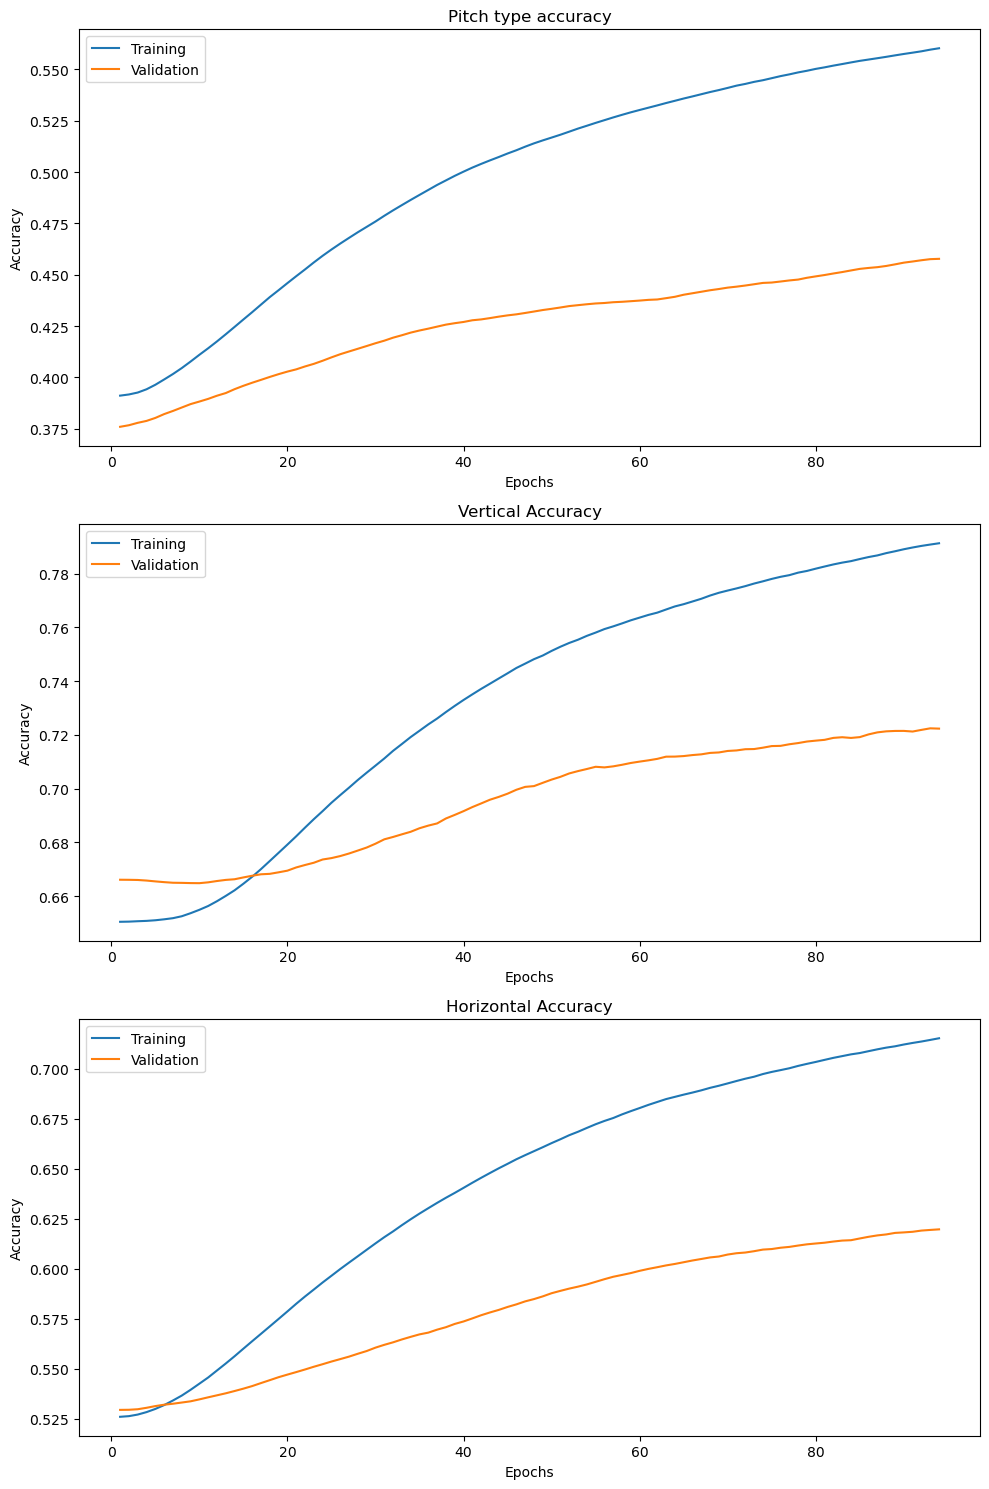

In [18]:
from utils.plot_utils import plot_ensemble_history

plot_ensemble_history(history)

In [7]:
tuner = keras_tuner.BayesianOptimization(
    build_model,
    objective=[keras_tuner.Objective('val_vertical_output_accuracy', direction='max'),
               keras_tuner.Objective('val_horizontal_output_accuracy', direction='max'),
               keras_tuner.Objective('val_pitch_output_accuracy', direction='max')],
    max_trials=10,
    project_name='Transformers_Ensemble'
)

tuner.search(X_train, 
             {'pitch_output': y_pitch_train,
              'vertical_output': y_vertical_train,
              'horizontal_output': y_horizontal_train},
             epochs=100, batch_size=64, 
             validation_data=(X_val, 
                              {'pitch_output': y_pitch_val,
                               'vertical_output': y_vertical_val,
                               'horizontal_output': y_horizontal_val}),
             callbacks=[freeze_output_callback],
            )

Trial 10 Complete [00h 08m 42s]
multi_objective: -2.039107620716095

Best multi_objective So Far: -2.148031532764435
Total elapsed time: 02h 58m 34s


In [10]:
import pandas as pd

# Get the tuner results
tuner_results = tuner.oracle.get_best_trials(num_trials=10)

# Extract relevant information
results = []
for trial in tuner_results:
    trial_summary = {
        'Trial ID': trial.trial_id,
        'Hidden layers': trial.hyperparameters.values['num_hidden_layers'],
        'Head size': trial.hyperparameters.values['head_size'],
        'Number of heads': trial.hyperparameters.values['num_heads'],
        'Feed forward dimension': trial.hyperparameters.values['ff_dim'],
        'Activation': trial.hyperparameters.values['activation'],
        'Score': trial.score,
        'Pitch Accuracy': trial.metrics.get_last_value('val_pitch_output_accuracy'),
        'Vertical Accuracy': trial.metrics.get_last_value('val_vertical_output_accuracy'),
        'Horizontal Accuracy': trial.metrics.get_last_value('val_horizontal_output_accuracy')
    }
    results.append(trial_summary)

# Create a DataFrame
results_df = pd.DataFrame(results)
results_df.to_csv('transformer_search_results.csv', index=False)

# Display the results
results_df

,Trial ID,Hidden layers,Head size,Number of heads,Feed forward dimension,Activation,Score,Pitch Accuracy,Vertical Accuracy,Horizontal Accuracy
0,06,2,64,4,256,relu,-2.148032,0.633990,0.790682,0.723360
1,07,3,32,6,128,tanh,-2.040157,0.600131,0.755118,0.684908
2,09,1,128,2,256,relu,-2.039108,0.572441,0.770997,0.695669
3,01,2,64,2,128,relu,-2.015879,0.587402,0.747638,0.680840
4,00,3,128,2,128,tanh,-1.995013,0.578084,0.748294,0.668635
5,04,1,64,2,256,relu,-1.968241,0.551181,0.753543,0.663517
6,05,2,128,4,256,sigmoid,-1.955512,0.567717,0.728346,0.659449
7,03,2,64,4,256,tanh,-1.952493,0.567585,0.722703,0.662205
8,08,1,256,4,128,sigmoid,-1.852231,0.481890,0.719029,0.651312
9,02,1,64,2,64,sigmoid,-1.761024,0.465879,0.710367,0.584777


In [ ]:
def build_model(hp):
    # Define the input layer
    input_layer = tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2]))

    pitch_output = build_network(input_layer, num_targets=num_pitches, name='pitch',
                                 num_hidden_layers=2,
                                 activation='relu',
                                 head_size=64,
                                 num_heads=4,
                                 ff_dim=256)
    
    vertical_output = build_network(input_layer, num_targets=num_vertical_locs, name='vertical',
                                    num_hidden_layers=hp.Int('num_hidden_layers', min_value=1, max_value=3, step=1),
                                    activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid']),
                                    head_size=hp.Choice('head_size', values=[32, 64, 128, 256]),
                                    num_heads=hp.Int('num_heads', min_value=2, max_value=4, step=2),
                                    ff_dim=hp.Choice('ff_dim', values=[64, 128, 256]))
    
    horizontal_output = build_network(input_layer, num_targets=num_horizontal_locs, name='horizontal',
                                      num_hidden_layers=hp.Int('num_hidden_layers', min_value=1, max_value=3, step=1),
                                      activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid']),
                                      head_size=hp.Choice('head_size', values=[32, 64, 128, 256]),
                                      num_heads=hp.Int('num_heads', min_value=2, max_value=4, step=2),
                                      ff_dim=hp.Choice('ff_dim', values=[64, 128, 256]))

    # Combine the models
    ensemble_model = tf.keras.models.Model(inputs=input_layer, outputs=[
                                           pitch_output, vertical_output, horizontal_output])

    # Compile the model
    ensemble_model.compile(optimizer='adam',
                           loss={'pitch_output': 'categorical_crossentropy',
                                 'vertical_output': 'categorical_crossentropy',
                                 'horizontal_output': 'categorical_crossentropy'},
                           metrics=['accuracy', 'accuracy', 'accuracy'])
    return ensemble_model